In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import seaborn as sns
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split
import scipy.integrate

from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import statsmodels.api as sm
import xlrd
import math

# Read in data

In [2]:
# COVID-19 cases
df_case = pd.read_csv("D:/Git/CS109A_Group58/02_Data//01_COVID/covid_us_county.csv")
df_case.dropna(inplace=True)

# Socio-Demographics
df_sd = pd.read_csv("D:/Git/CS109A_Group58/02_Data//02_SociaDemographics/us_final.csv",index_col=0)
df_sd = df_sd.reset_index()

# Policy
df_policy = pd.read_excel(r"D:/Git/CS109A_Group58/02_Data\03_Policy\COVID_StatePolicy_final.xlsx")
df_policy.head()

# Mobility
df_mobility = pd.read_csv("D:/Git/CS109A_Group58/02_Data//05_Mobility/2020_US_Region_Mobility_Report.csv")

## Preprocess and clean data

In [3]:
df_case

,fips,county,state,lat,long,date,cases,state_code,deaths
0,1001.0,Autauga,Alabama,32.539527,-86.644082,2020-01-22,0,AL,0
1,1001.0,Autauga,Alabama,32.539527,-86.644082,2020-01-23,0,AL,0
2,1001.0,Autauga,Alabama,32.539527,-86.644082,2020-01-24,0,AL,0
3,1001.0,Autauga,Alabama,32.539527,-86.644082,2020-01-25,0,AL,0
4,1001.0,Autauga,Alabama,32.539527,-86.644082,2020-01-26,0,AL,0
...,...,...,...,...,...,...,...,...,...
945215,56045.0,Weston,Wyoming,43.839612,-104.567488,2020-10-26,132,WY,0
945216,56045.0,Weston,Wyoming,43.839612,-104.567488,2020-10-27,139,WY,0
945217,56045.0,Weston,Wyoming,43.839612,-104.567488,2020-10-28,148,WY,0
945218,56045.0,Weston,Wyoming,43.839612,-104.567488,2020-10-29,155,WY,0


# Calculate R0

### Formula

$$
R_{0}=\left(1+r \bar{T}_{L}\right)\left(1+r \bar{T}_{I}\right)
$$

$$
b(t)=b(t-\Delta t) e^{r \Delta t}
$$

$$
\bar{T}_{I}= \bar{S}{I} - \bar{T}_{L}
$$


$
\bar{T}_{L}\ \ is\ mean\ latent\ period.
$ 

$
\bar{T}_{I}\ \ is\ mean\ infectious\ period.
$

$
\bar{S}{I}\ \ is\ serial \ interval
$

$
r\ \ is\ reproductive \ rate.
$


Reference: \
Wallinga, J., & Lipsitch, M. (2007). How generation intervals shape the relationship between growth rates and reproductive numbers. Proceedings of the Royal Society B: Biological Sciences, 274(1609), 599-604.\
https://zhuanlan.zhihu.com/p/106983592

### Parameters Explanation

The latent period is the time from acquiring infection to the onset of infectiousness. The duration of the latent period is characteristic of particular infections.

The infectious period is the time during which someone with an infection can transmit the infection to someone else. The degree of infectiousness varies through the infectious period. 

If the latent period is shorter than the incubation period, then individuals are infectious before they have symptoms. This can help the infection to spread more easily.
If the latent period is longer than the incubation period, then people are infectious only after symptoms start. This means they can be recognised as being ill before they are infectious.


### Parameters values

Set $\bar{T}_{L}$ to 2.0, based on https://en.wikipedia.org/wiki/Latent_period_(epidemiology)#cite_note-pmid32296168-4

Set $\bar{S}{I}$ to 5.8, based on He, X., Lau, E.H.Y., Wu, P. et al. Temporal dynamics in viral shedding and transmissibility of COVID-19. Nat Med 26, 672–675 (2020). https://doi.org/10.1038/s41591-020-0869-5


In [15]:
# beta = - dS_dt/(S * I)  

# dS_dt 新增感染
# S 前一天易感染
# I 前一天感染


In [5]:
# COVID-19 cases
mData1 = []
df_case['fips'] = df_case.fips.astype(int)
df_sir = df_case.copy()
fips = list(set(df_sir['fips']))
for fip in tqdm(fips):
    df = df_sir[(df_sir['fips']==fip)]
    
    df = df[df['cases']>=5]
    df = df.reset_index(drop=True)
    df = df.reset_index()

    df = df.to_dict("records")
    # 7 day Moving average
    for i in range(len(df)-6):
        mdf = df[i:i+7]
        mdf_case = [m['cases'] for m in mdf]
        mdf_death = [m['deaths'] for m in mdf]
        df[i+3]['cases_7'] = np.sum(mdf_case)/7
        df[i+3]['deaths_7'] = np.sum(mdf_death)/7
        df[i+3]['day_index'] = df[i+3]['index']
        mData1.append(df[i+3])


for i in range(len(mData1)-1):
    # The log value
    mData1[i+1]['delta_case'] = np.log(mData1[i+1]['cases_7']) - np.log(mData1[i]['cases_7'])
    # new cases
    mData1[i+1]['new_cases'] = mData1[i+1]['cases'] - mData1[i]['cases']
    pass
del mData1[0]

df_case_delta = pd.DataFrame(mData1)

df_case_delta = pd.merge(df_case_delta,df_sd[["fips", "population_2017"]])

100%|██████████████████████████████████████████████████████████████████████████████| 3241/3241 [00:36<00:00, 89.35it/s]


In [273]:
#### CSV 给宇宸 ####

SI = 5.7
TL = 2
TI = SI - TL
gamma = 0.1

# COVID-19 cases
mData1 = []
df_case_delta['fips'] = df_case_delta.fips.astype(int)
df_sir = df_case_delta.copy()
fips = list(set(df_sir['fips']))
for fip in tqdm(fips):
    df = df_sir[(df_sir['fips']==fip)]
    df = df.to_dict("records")
    
    # new cases 7 day Moving average
    for i in range(len(df)-6):
        mdf = df[i:i+7]
        mdf_case = [m['new_cases'] for m in mdf]
        df[i+3]['new_cases_7'] = np.sum(mdf_case)/7
        if df[i+3]['new_cases_7'] == 0:
            df[i+3]['new_cases_7'] = 0.5        
        df[i+3]['day_index'] = df[i+3]['index']
        
        mData1.append(df[i+3])

for i in range(len(mData1)-1):
    # Calcu Beta 
    mData1[i]['beta_1'] = (mData1[i+1]['new_cases'] * mData1[i]['population_2017'])/ ((mData1[i]['population_2017'] - mData1[i]['cases']) * mData1[i]['cases'])
#     # r and beta
#     mData1[i+1]['r'] = np.log(mData1[i+1]['new_cases_7']) - np.log(mData1[i]['new_cases_7'])
#     mData1[i+1]['R0'] = (1 + mData1[i+1]['r'] * TL) * (1 + mData1[i+1]['r'] * TI)
#     mData1[i+1]['beta'] = mData1[i+1]['R0'] * gamma
#     mData1[i+1]['p_new_cases'] = mData1[i]['beta_1'] * ((mData1[i]['population_2017'] - mData1[i]['cases']) * mData1[i]['cases']) / mData1[i]['population_2017'] 
    pass
del mData1[0]

df_case_R0 = pd.DataFrame(mData1)

df_case_R0.to_csv('D:\\Git\\CS109A_Group58\\02_Data\\01_COVID\\covid_county_Beat.csv',index=False,header=True)  

100%|█████████████████████████████████████████████████████████████████████████████| 3100/3100 [00:23<00:00, 132.07it/s]


In [132]:
SI = 5.7
TL = 2
TI = SI - TL
gamma = 0.1

# COVID-19 cases
mData1 = []
df_case_delta['fips'] = df_case_delta.fips.astype(int)
df_sir = df_case_delta.copy()
fips = list(set(df_sir['fips']))
for fip in tqdm(fips):
    df = df_sir[(df_sir['fips']==fip)]
    df = df.to_dict("records")
    
    # new cases 7 day Moving average
    for i in range(len(df)-6):
        mdf = df[i:i+7]
        mdf_case = [m['new_cases'] for m in mdf]
        df[i+3]['new_cases_7'] = np.sum(mdf_case)/7
        if df[i+3]['new_cases_7'] == 0:
            df[i+3]['new_cases_7'] = 0.5        
        df[i+3]['day_index'] = df[i+3]['index']
        
        mData1.append(df[i+3])

for i in range(len(mData1)-1):
    # Calcu Beta 
    mData1[i]['beta_1'] = (mData1[i+1]['new_cases'] * mData1[i]['population_2017'])/ ((mData1[i]['population_2017'] - mData1[i]['cases']) * mData1[i]['cases'])
    # r and beta
    mData1[i+1]['r'] = np.log(mData1[i+1]['new_cases_7']) - np.log(mData1[i]['new_cases_7'])
    mData1[i+1]['R0'] = (1 + mData1[i+1]['r'] * TL) * (1 + mData1[i+1]['r'] * TI)
    mData1[i+1]['beta'] = mData1[i+1]['R0'] * gamma
#     mData1[i+1]['p_new_cases'] = mData1[i]['beta_1'] * ((mData1[i]['population_2017'] - mData1[i]['cases']) * mData1[i]['cases']) / mData1[i]['population_2017'] 
    pass
del mData1[0]

df_case_R0 = pd.DataFrame(mData1)


100%|█████████████████████████████████████████████████████████████████████████████| 3100/3100 [00:23<00:00, 131.01it/s]
<ipython-input-132-3915cdc1d776>:30: RuntimeWarning: invalid value encountered in log
  mData1[i+1]['r'] = np.log(mData1[i+1]['new_cases_7']) - np.log(mData1[i]['new_cases_7'])


In [133]:
# df_case_R0[(df_case_R0['beta']>=8.8)|(df_case_R0['index']==119)&(df_case_R0['fips'] == 48029)]
# df_case_R0[(df_case_R0['new_cases_7']==0)]

In [134]:
display(df_case_R0[:55])
df_case_R0.describe()

,index,fips,county,state,lat,long,date,cases,state_code,deaths,...,deaths_7,day_index,delta_case,new_cases,population_2017,new_cases_7,r,R0,beta,beta_1
0,8,41001,Baker,Oregon,44.709156,-117.674988,2020-07-12,12,OR,0,...,0.000000,8,0.067139,1,15984,0.714286,-0.336472,-0.080111,-0.008011,0.000000
1,9,41001,Baker,Oregon,44.709156,-117.674988,2020-07-13,12,OR,0,...,0.000000,9,0.062914,0,15984,0.714286,0.000000,1.000000,0.100000,0.000000
2,10,41001,Baker,Oregon,44.709156,-117.674988,2020-07-14,12,OR,0,...,0.000000,10,0.047628,0,15984,0.571429,-0.223144,0.096550,0.009655,0.083396
3,11,41001,Baker,Oregon,44.709156,-117.674988,2020-07-15,13,OR,0,...,0.000000,11,0.022990,1,15984,0.285714,-0.693147,0.604413,0.060441,0.000000
4,12,41001,Baker,Oregon,44.709156,-117.674988,2020-07-16,13,OR,0,...,0.000000,12,0.011300,0,15984,0.142857,-0.693147,0.604413,0.060441,0.000000
5,13,41001,Baker,Oregon,44.709156,-117.674988,2020-07-17,13,OR,0,...,0.000000,13,0.011173,0,15984,0.142857,0.000000,1.000000,0.100000,0.000000
6,14,41001,Baker,Oregon,44.709156,-117.674988,2020-07-18,13,OR,0,...,0.000000,14,0.032790,0,15984,0.428571,1.098612,16.193512,1.619351,0.000000
7,15,41001,Baker,Oregon,44.709156,-117.674988,2020-07-19,13,OR,0,...,0.000000,15,0.031749,0,15984,0.428571,0.000000,1.000000,0.100000,0.000000
8,16,41001,Baker,Oregon,44.709156,-117.674988,2020-07-20,13,OR,0,...,0.000000,16,0.030772,0,15984,0.428571,0.000000,1.000000,0.100000,0.153971
9,17,41001,Baker,Oregon,44.709156,-117.674988,2020-07-21,15,OR,0,...,0.000000,17,0.039609,2,15984,0.571429,0.287682,3.252219,0.325222,0.066729


,index,fips,lat,long,cases,deaths,cases_7,deaths_7,day_index,delta_case,new_cases,population_2017,new_cases_7,r,R0,beta,beta_1
count,553427.000000,553427.000000,553427.000000,553427.000000,553427.000000,553427.000000,553427.000000,553427.000000,553427.000000,553427.000000,553427.000000,5.534270e+05,553427.000000,541969.000000,541969.000000,541969.000000,553426.000000
mean,99.647914,30064.651389,38.143377,-91.131681,1412.373099,49.625902,1412.593896,49.627400,99.647914,0.022842,15.123341,1.229482e+05,12.906466,0.011271,1.793516,0.179352,0.024404
std,57.290347,15232.582668,5.128168,12.487653,6652.173738,288.811268,6651.650837,288.744484,57.290347,0.030654,77.270923,3.682439e+05,133.954910,0.313725,3.446885,0.344688,0.078746
min,6.000000,1001.000000,19.601212,-174.159600,5.000000,0.000000,5.000000,0.000000,6.000000,-0.502457,-2545.000000,4.540000e+02,-43150.285714,-5.099866,-0.097635,-0.009764,-0.795395
25%,50.000000,18101.000000,34.442441,-96.768555,43.000000,0.000000,43.142857,0.571429,50.000000,0.006101,0.000000,1.473000e+04,0.714286,-0.068823,0.698373,0.069837,0.000000
50%,96.000000,29073.000000,38.116241,-89.036368,171.000000,3.000000,170.857143,3.000000,96.000000,0.013805,2.000000,3.295600e+04,2.571429,0.000000,1.000000,0.100000,0.007976
75%,147.000000,45023.000000,41.567427,-82.846913,669.000000,17.000000,669.285714,16.571429,147.000000,0.028052,9.000000,8.777600e+04,9.142857,0.093090,1.680081,0.168008,0.025878
max,238.000000,56045.000000,69.314792,-67.628135,298937.000000,7382.000000,297537.142857,7381.142857,238.000000,1.865678,14129.000000,1.009805e+07,3283.571429,5.557379,261.222117,26.122212,30.932393


# SIR Model 

SIR model is a classical theory model for the prediction of pandemic. It splits the population into three compartments including Susceptible, Infectious and Recovered. The theory allows us to describe the number of people in each compartment with the ordinary differential equation thus easy to get the step-wise simulation. 

$$\frac{d S}{d t}=-\beta I S$$
$$\frac{d I}{d t}=\beta I S-\gamma I$$
$$\frac{d R}{d t}=\gamma I$$

There are 2 determinant parameters in the model. β represents the number of people that an infected person could affect. γ represents the chance for an infected person to get recovered. Another important idea which is usually mentioned is R0, the basic reproduction number. This is an epidemiologic metric used to describe the contagiousness of a pandemic which could be calculated by:

$$R_{0}=\frac \beta \gamma$$

Set $\gamma$ to 0.1, according to https://arxiv.org/abs/2003.13901v1 and https://www.who.int/bulletin/online_first/20-255695.pdf 

In [259]:
import scipy.integrate
from datetime import datetime, timedelta
# model


# Get date list from begin_date to end_date
def get_date_list(begin_date, end_date):
    dates = []
    # Get the time tuple : dt
    dt = datetime.strptime(begin_date, "%Y-%m-%d")
    date = begin_date[:]
    while date <= end_date:
        if dt.strftime("%w") in ["0","1","2","3","4","5","6"]:  #######输入周几#######
            dates.append(date)
        dt += timedelta(days=1)
        date = dt.strftime("%Y-%m-%d")
    return dates


def days_count(begin_date, end_date):
    """Count how many days there between begin_date and end_date.
    Input format: Str. eg: '2020-05-10'
    Return: Int
    """
    begin_date = datetime.strptime(begin_date, '%Y-%m-%d')
    end_date = datetime.strptime(end_date, '%Y-%m-%d')
    delta_days = end_date - begin_date
    return delta_days.days


def SIR_model(y, t, beta, gamma):
    """
    Play with scipy.odeint 微分方程函数

    """    
    S, I, R = y
    dS_dt = -beta * S * I
    dI_dt = beta * S * I - gamma * I
    dR_dt = gamma * I
    return ([dS_dt, dI_dt, dR_dt])

def SIR_Phase_Model():
    """Calcute SIR in phases with changing parameter
    Return: ndarray(n,3). [[S_ratio, I_ratio, R_ratio],...]
            ndarray(n,3). [[S_num, I_num, R_num],...]
    """
    for i in range(len(date_list)-1):
        # parameters
        gamma = 0
        beta = beta_list[i]
        S0 = S0_list[i]
        I0 = I0_list[i]
        R0 = R0_list[i]

        # time vector
        days = days_count(date_list[i], date_list[i+1])
        days_sequence.append(days_count(date_list[0], date_list[i+1]))
        t = np.linspace(0, days, days+1)

        # result in ratio with function: SIR_model
        res_dict[i] = scipy.integrate.odeint(SIR_model, [S0, I0, R0], t, args=(beta, gamma))
        # result in population with function: SIR_model
        res_dict_num[i] = scipy.integrate.odeint(SIR_model, [S0, I0, R0], t, args=(beta, gamma))*df_temp['population_2017'].values[0]

        # update initial S I R population number for next phase 
        S0_list.append(res_dict[i][-1][0])
        I0_list.append(res_dict[i][-1][1])
        R0_list.append(res_dict[i][-1][2])
        
        
        # append result of this phase
        if i >0:
            res_dict[i] = np.append(res_dict[i-1],res_dict[i][1:], axis=0) 
            res_dict_num[i] = np.append(res_dict_num[i-1],res_dict_num[i][1:], axis=0) 
#         print(res_dict[i].shape)

    return res_dict[len(date_list)-2], res_dict_num[len(date_list)-2]

In [260]:
# SIR Predict
res_dict = {}
res_dict_num = {}
result_dict = {}
result_dict_num = {}
predcase_dict = {}
days_sequence =[]

####################
# INPUT PARAMETERS #
####################
date_list = ['2020-05-01', '2020-05-02', '2020-05-03', '2020-05-04', '2020-05-05', '2020-05-06', '2020-05-07', '2020-05-08']
date_list = ['2020-05-01', '2020-05-08', '2020-05-15', '2020-05-22', '2020-05-29', '2020-06-05', '2020-06-12', '2020-06-19']
date_list = get_date_list('2020-05-01','2020-07-19')

# gamma_list = [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
# gamma_list = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
# gamma_list = [0, 0, 0, 0, 0, 0, 0]

df_case_De_R0 = df_case_R0.copy()


for fip in tqdm(fips[8:9]):     #counties to be calcu
    # Set County to calcu
    df1 = df_case_De_R0[(df_case_De_R0['fips'] == fip )]
    
    # Set parameters of initial day 
    beta_list = []
    for n in range(len(date_list)-1):
        df_temp = df1[(df1['date'] == date_list[n])]
        beta_list.append(df_temp['beta_1'].values[0]) 
        
        
    df_temp = df1[(df1['date'] == date_list[0] )]
    S0_list = [1 - df_temp['cases_7'].values[0]/(df_temp['population_2017'].values[0])]
    I0_list = [df_temp['cases'].values[0]/(df_temp['population_2017'].values[0])]
    R0_list = [0]
    
    # Predict use function: SIR_Phase_Model() 
    result_dict[fip], result_dict_num[fip] = SIR_Phase_Model()

# X_axis Time use to plot
days = days_count(date_list[0], date_list[-1])
T = np.linspace(0, days, days+1)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.03it/s]


In [261]:
# beta_list
# p = df1['population_2017'].values[0]
# I0_list[0]*p

76.0

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.04it/s]


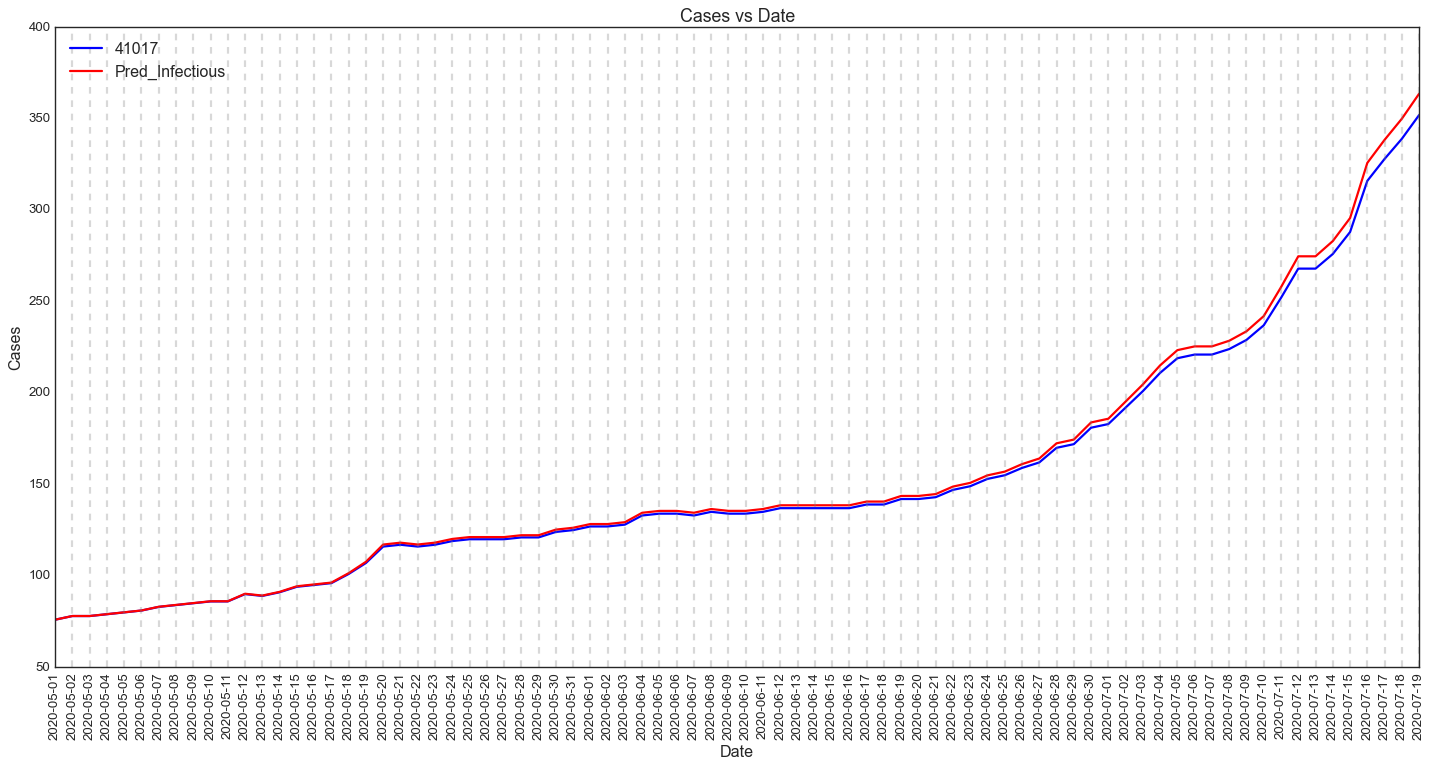

In [271]:
df_case_R0['fips'] = df_case_R0.fips.astype(int)
df_sir1 = df_case_R0.copy()
fips = list(set(df_sir1['fips']))

plt.style.use('seaborn-white')
fig = plt.figure(figsize=(22,10))

for fip in tqdm(fips[8:9]):

    df1 = df_case_R0[(df_case_R0['fips'] == fip )]
    df_temp1 = df1[(df1['date']>=date_list[0])&(df1['date']<=date_list[-1])]
    
    plt.plot(df_temp1['date'], df_temp1['cases'], label=fip, c='b')
    plt.xticks(rotation=90)
    
    plt.plot(df_temp1['date'], result_dict_num[fips[8:9][0]][:, 1], c='r', label='Pred_Infectious')
    for i in range(len(date_list)-1):
        plt.axvline(x=days_sequence[i], color='grey', linestyle='--', alpha=0.3)
    
    plt.title("Cases vs Date",fontsize=16)
    plt.xlabel("Date")
    plt.ylabel("Cases")
    plt.legend(fontsize='large',loc='upper left')
#     plt.legend(fontsize='large',bbox_to_anchor=(1.05, 1),loc='upper left')
plt.show()



In [258]:
print(result_dict_num[fips[8:9][0]][:, 1])
print(df_temp1['cases'])

[ 76.          78.02672528  80.10744638  82.24354416  84.43666357
  86.68784105  88.99891911  91.37162544  92.46585234  93.57317345
  94.69373929  95.82772691  96.97524799  98.13648971  99.31162471
 100.37374898 101.44722383 102.53216578 103.62871176 104.73694835
 105.85701963 106.98905825 107.91541461 108.84978559 109.79223782
 110.74284941 111.70166964 112.66878009 113.64425573 116.49743061
 119.42215587 122.42015329 125.49346962 128.64338314 131.87218739
 135.18203729 135.18203729 135.18203729 135.18203729 135.18203729
 135.18203729 135.18203729 135.18203729 135.18203729 135.18203729
 135.18203729 135.18203729 135.18203729 135.18203729 135.18203729
 135.18203729 135.18203729 135.18203729 135.18203729 135.18203729
 135.18203729 135.18203729 137.75729824 140.38156271 143.05572557
 145.78084444 148.55757175 151.38706304 154.27039932 162.14264631
 170.41582815 179.11092722 188.24661024 197.84904495 207.94163016
 218.54816504 232.83011547 248.04335258 264.24575688 281.50733145
 299.89497

KeyError: 41017

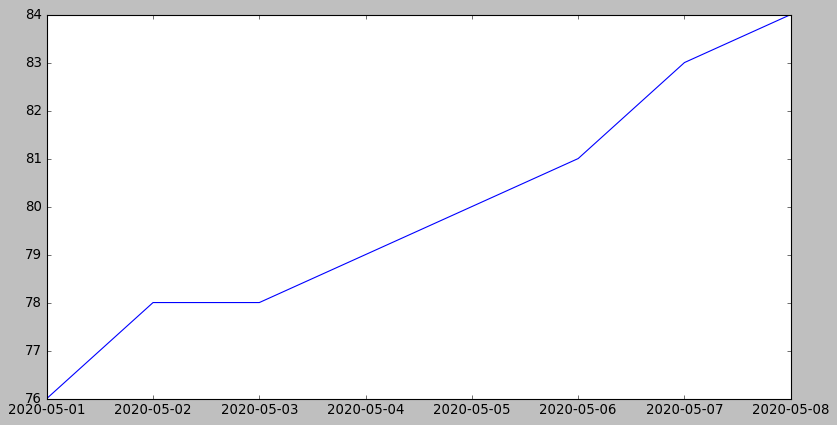

In [131]:
#plot

plt.figure(figsize=[12, 6])

df1 = df_case_R0[(df_case_R0['fips'] == fips[8:9][0] )]
df_temp1 = df1[(df1['date']>=date_list[0])&(df1['date']<=date_list[-1])]

plt.plot(df_temp1['date'], df_temp1['cases'], label=fips[8:9][0])


# plt.plot(T, result_dict_num[fips[8:9][0]][:, 0], label='S')
plt.plot(date_list, result_dict_num[fips[8:9][0]][:, 1], label='I')
plt.xticks(rotation=90)#旋转45度显示
# plt.plot(T, result_dict_num[fips[8:9][0]][:, 2], label='R')
for i in range(len(date_list)-1):
    plt.axvline(x=days_sequence[i], color='grey', linestyle='--')
plt.legend()

plt.grid()
plt.xlabel('time')
plt.ylabel('proportions')
plt.title('SIR model simulation')
plt.show()

In [ ]:
# datetime function

In [194]:
import time
from datetime import datetime, timedelta

def get_date_list(begin_date, end_date):
    dates = []
    # Get the time tuple : dt
    dt = datetime.strptime(begin_date, "%Y-%m-%d")
    date = begin_date[:]
    while date <= end_date:
        dates.append(date)
        dt += timedelta(days=1)
        date = dt.strftime("%Y-%m-%d")
    return dates
date_list = get_date_list('2020-05-01','2020-06-19')

In [212]:
import time
from datetime import datetime, timedelta
# Get date list from begin_date to end_date
def get_date_list(begin_date, end_date):
    dates = []
    # Get the time tuple : dt
    dt = datetime.strptime(begin_date, "%Y-%m-%d")
    date = begin_date[:]
    while date <= end_date:
        if dt.strftime("%w") in ["5"]:
            dates.append(date)
        dt += timedelta(days=1)
        date = dt.strftime("%Y-%m-%d")
    return dates
date_list = get_date_list('2020-05-01','2020-10-19')
date_list[0]

'2020-05-01'

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.71it/s]


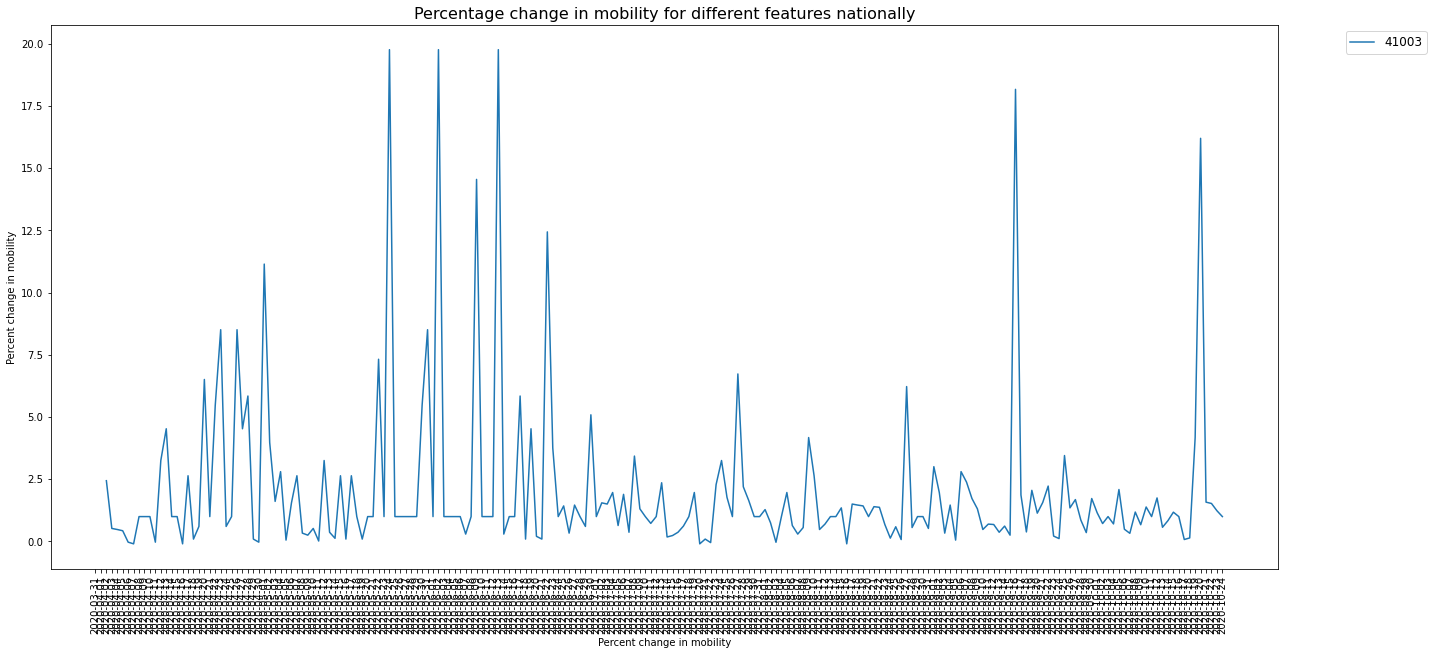

In [19]:
df_case_R0['fips'] = df_case_R0.fips.astype(int)
df_sir1 = df_case_R0.copy()
fips = list(set(df_sir1['fips']))
    
fig = plt.figure(figsize=(22,10))

for fip in tqdm(fips[1:2]):

    df1 = df_case_R0[(df_case_R0['fips'] == fip )]
    
    plt.plot(df1['date'], df1['R0'], label=fip)
    plt.xticks(rotation=90)#旋转45度显示
    plt.title("Percentage change in mobility for different features nationally",fontsize=16)
    plt.xlabel("Percent change in mobility")
    plt.ylabel("Percent change in mobility")
    plt.legend(fontsize='large',bbox_to_anchor=(1.05, 1),loc='upper left')
    
plt.show()

# Calculate R0

### Formula

$$
R_{0}=\left(1+r \bar{T}_{L}\right)\left(1+r \bar{T}_{I}\right)
$$

$$
b(t)=b(t-\Delta t) e^{r \Delta t}
$$

$$
\bar{T}_{I}= \bar{S}{I} - \bar{T}_{L}
$$


$
\bar{T}_{L}\ \ is\ mean\ latent\ period.
$ 

$
\bar{T}_{I}\ \ is\ mean\ infectious\ period.
$

$
\bar{S}{I}\ \ is\ serial \ interval
$

$
r\ \ is\ reproductive \ rate.
$


Reference: \
Wallinga, J., & Lipsitch, M. (2007). How generation intervals shape the relationship between growth rates and reproductive numbers. Proceedings of the Royal Society B: Biological Sciences, 274(1609), 599-604.\
https://zhuanlan.zhihu.com/p/106983592

### Parameters Explanation

The latent period is the time from acquiring infection to the onset of infectiousness. The duration of the latent period is characteristic of particular infections.

The infectious period is the time during which someone with an infection can transmit the infection to someone else. The degree of infectiousness varies through the infectious period. 

If the latent period is shorter than the incubation period, then individuals are infectious before they have symptoms. This can help the infection to spread more easily.
If the latent period is longer than the incubation period, then people are infectious only after symptoms start. This means they can be recognised as being ill before they are infectious.


### Parameters values

Set $\bar{T}_{L}$ to 2.0, based on https://en.wikipedia.org/wiki/Latent_period_(epidemiology)#cite_note-pmid32296168-4

Set $\bar{S}{I}$ to 5.8, based on He, X., Lau, E.H.Y., Wu, P. et al. Temporal dynamics in viral shedding and transmissibility of COVID-19. Nat Med 26, 672–675 (2020). https://doi.org/10.1038/s41591-020-0869-5


In [ ]:
df_case_delta = df_case_delta[(df_case_delta['cases_7']>=10)&(df_case_delta['date']>="2020-03-01")&(df_case_delta['date']<"2020-10-01")&(df_case_delta['delta_case']>0)]
df_case_delta.dropna(inplace=True)
df_case_delta

In [ ]:
# b(t)/b(t-dt) = e^r*dt
# log(b(t)/b(t-dt)) / dt = r

# r = math.log(b(t)/b(t-dt)) / dt


In [ ]:
SI = 5.7
TL = 2
TI = SI - TL
gamma = 0.1
dt = 1

# Add R0 Column
mData1 = []
df_case_delta['fips'] = df_case_delta.fips.astype(int)
df_sir = df_case_delta.copy()
fips = list(set(df_sir['fips']))
for fip in tqdm(fips):
    df = df_sir[(df_sir['fips']==fip)]    
    df = df[df['cases']>=5]
    df = df.to_dict("records")
    
    # Calcu R0_dt
    for i in range(len(df)-1):
        
        mdf = df[i+1-dt:i+2]
        mdf_case = [m['cases'] for m in mdf]

#       r = math.log(b(t)/b(t-dt))/dt  ### R0<1, when r<0, when b(t)<b(t-dt) 
        r = math.log(mdf_case[i+1] / mdf_case[i+1-dt]) / dt
        
        df[i+1]['R0_30'] = (1 + r * TL) * (1 + r * TI)
        
        df[i+1]['day_index'] = df[i+1]['index']
        mData1.append(df[i+1])
        
        
    # Calcu R0 
    for i in range(len(df)-1):
        mdf = df[i:i+2]
        mdf_case = [m['cases'] for m in mdf]
        mdf_case_7 = [m['cases_7'] for m in mdf]
        
        df[i+1]['R0'] = (1 + math.log(mdf_case[1]/mdf_case[0]) * TL) * (1 + math.log(mdf_case[1]/mdf_case[0]) * TI)
        df[i+1]['R0_7'] = (1 + math.log(mdf_case_7[1]/mdf_case_7[0]) * TL) * (1 + math.log(mdf_case_7[1]/mdf_case_7[0]) * TI)
        
        df[i+1]['day_index'] = df[i+1]['index']
        mData1.append(df[i+1])

df_case_R0 = pd.DataFrame(mData1)

In [ ]:
df_case_R0[:50]

In [ ]:
df_case_R0.describe()

In [ ]:
df_case_De_R0 = pd.merge(df_case_R0,df_sd.drop(columns=["index","Race_White","WorkType_Office","Transp_Drive","Work_PrivateWork","IncomeErr","IncomePerCapErr","county","state","state_code","Crime_AG_ARRST"]+crime_columns),left_on="fips",right_on="fips")

In [ ]:
df_case_R0['fips'] = df_case_R0.fips.astype(int)
df_sir1 = df_case_R0.copy()
fips = list(set(df_sir1['fips']))
    
plt.figure(figsize=(16,9))

for fip in tqdm(fips[:1]):
    
    df1 = df_case_R0[(df_case_R0['fips'] == fip )]
    g=sns.lineplot(x="date", y="R0_A",ci=None, data=df1,label = fip)
    locator = mdates.AutoDateLocator()
    formatter = mdates.ConciseDateFormatter(locator,formats=["","%b", '%d', '%H:%M', '%H:%M', '%S.%f'],show_offset=False)
    g.xaxis.set_major_locator(locator)
    g.xaxis.set_major_formatter(formatter)
    g.set_xlim(df_case_R0['date'].min(),df_case_R0['date'].max())
    g.set_xlabel('Date')
    g.set_ylabel('Daily new cases per county')
    plt.title("Newly confirmed cases",fontsize=16)

plt.show()

In [ ]:
df_case_R0['fips'] = df_case_R0.fips.astype(int)
df_sir1 = df_case_R0.copy()
fips = list(set(df_sir1['fips']))
    
plt.figure(figsize=(16,9))

for fip in tqdm(fips[:55]):
    
    df1 = df_case_R0[(df_case_R0['fips'] == fip )]
    
    g=sns.lineplot(x="day_index", y="R0_7",ci=None, data=df1,label = fip)
    g.set_xlabel('day_index')
    g.set_ylabel('Daily R0')
    g.axhline(y=1, color='r', linestyle='--')

    plt.legend(loc='upper right',fontsize=11) 
    plt.title("R0",fontsize=16)
    
plt.show()

# SIR Model 

SIR model is a classical theory model for the prediction of pandemic. It splits the population into three compartments including Susceptible, Infectious and Recovered. The theory allows us to describe the number of people in each compartment with the ordinary differential equation thus easy to get the step-wise simulation. 

$$\frac{d S}{d t}=-\beta I S$$
$$\frac{d I}{d t}=\beta I S-\gamma I$$
$$\frac{d R}{d t}=\gamma I$$

There are 2 determinant parameters in the model. β represents the number of people that an infected person could affect. γ represents the chance for an infected person to get recovered. Another important idea which is usually mentioned is R0, the basic reproduction number. This is an epidemiologic metric used to describe the contagiousness of a pandemic which could be calculated by:

$$R_{0}=\frac \beta \gamma$$

Set $\gamma$ to 0.1, according to https://arxiv.org/abs/2003.13901v1 and https://www.who.int/bulletin/online_first/20-255695.pdf 

In [ ]:
import scipy.integrate
import datetime
# model

def days_count(begin_date, end_date):
    """Count how many days there between begin_date and end_date.
    Input format: Str. eg: '2020-05-10'
    Return: Int
    """
    begin_date = datetime.datetime.strptime(begin_date, '%Y-%m-%d')
    end_date = datetime.datetime.strptime(end_date, '%Y-%m-%d')
    delta_days = end_date - begin_date
    return delta_days.days


def SIR_model(y, t, beta, gamma):
    """
    Play with scipy.odeint 微分方程函数

    """    
    S, I, R = y
    dS_dt = -beta * S * I
    dI_dt = beta * S * I - gamma * I
    dR_dt = gamma * I
    return ([dS_dt, dI_dt, dR_dt])

def SIR_Phase_Model():
    """Calcute SIR in phases with changing parameter
    Return: ndarray(n,3). [[S_ratio, I_ratio, R_ratio],...]
            ndarray(n,3). [[S_num, I_num, R_num],...]
    """
    for i in range(len(date_list)-1):
        # parameters
        gamma = gamma_list[i]
        beta = beta_list[i]
        S0 = S0_list[i]
        I0 = I0_list[i]
        R0 = R0_list[i]

        # time vector
        days = days_count(date_list[i], date_list[i+1])
        days_sequence.append(days_count(date_list[0], date_list[i+1]))
        t = np.linspace(0, days, days+1)

        # result in ratio with function: SIR_model
        res_dict[i] = scipy.integrate.odeint(SIR_model, [S0, I0, R0], t, args=(beta, gamma))
        # result in population with function: SIR_model
        res_dict_num[i] = scipy.integrate.odeint(SIR_model, [S0, I0, R0], t, args=(beta, gamma))*df_temp['population_2017'].values[0]

        # update initial S I R population number for next phase 
        S0_list.append(res_dict[i][-1][0])
        I0_list.append(res_dict[i][-1][1])
        R0_list.append(res_dict[i][-1][2])
        
        
        # append result of this phase
        if i >0:
            res_dict[i] = np.append(res_dict[i-1],res_dict[i][1:], axis=0) 
            res_dict_num[i] = np.append(res_dict_num[i-1],res_dict_num[i][1:], axis=0) 
#         print(res_dict[i].shape)

    return res_dict[len(date_list)-2], res_dict_num[len(date_list)-2]

In [ ]:
# SIR Predict
res_dict = {}
res_dict_num = {}
result_dict = {}
result_dict_num = {}
predcase_dict = {}
days_sequence =[]

####################
# INPUT PARAMETERS #
####################
date_list = ['2020-05-10', '2020-07-10', '2020-8-1','2020-9-1', '2021-5-10']
gamma_list = [0.1, 0.2, 0.1, 0.1]

for fip in tqdm(fips[1:5]):     #counties to be calcu
    # Set County to calcu
    df1 = df_case_De_R0[(df_case_De_R0['fips'] == fip )]
    
    # Set parameters of initial day 
    df_temp = df1[(df1['date'] == date_list[0] )]
    beta_list = [df_temp['delta_case'].values[0]*9, 0.19 , 0.35, 0.15  ]
    S0_list = [1 - df_temp['cases_7'].values[0]/(df_temp['population_2017'].values[0])]
    I0_list = [df_temp['cases_7'].values[0]/(df_temp['population_2017'].values[0])]
    R0_list = [0]
    
    # Predict use function: SIR_Phase_Model() 
    result_dict[fip], result_dict_num[fip] = SIR_Phase_Model()

# X_axis Time use to plot
days = days_count(date_list[0], date_list[-1])
T = np.linspace(0, days, days+1)

In [ ]:
#plot
plt.style.use('classic')

plt.figure(figsize=[12, 6])
plt.plot(T, result_dict[41005][:, 0], label='S(t)')
plt.plot(T, result_dict[41005][:, 1], label='I(t)')
plt.plot(T, result_dict[41005][:, 2], label='R(t)')
for i in range(len(date_list)-1):
    plt.axvline(x=days_sequence[i], color='black', linestyle='--')
plt.legend()
plt.grid()
plt.xlabel('time')
plt.ylabel('proportions')
plt.title('SIR model simulation')
plt.show()

In [ ]:
#plot
plt.style.use('classic')

plt.figure(figsize=[12, 6])
plt.plot(T, result_dict_num[41005][:, 0], label='S')
plt.plot(T, result_dict_num[41005][:, 1], label='I')
plt.plot(T, result_dict_num[41005][:, 2], label='R')
for i in range(len(date_list)-1):
    plt.axvline(x=days_sequence[i], color='black', linestyle='--')
plt.legend()
plt.grid()
plt.xlabel('time')
plt.ylabel('proportions')
plt.title('SIR model simulation')
plt.show()